# 🛍️ Project: Personalized E-commerce Recommendations

Goal: Predict whether a user will purchase a recommended item using classification, 
and rank items per user using scoring and validation tools.

In [97]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score,
    learning_curve, permutation_test_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report, roc_auc_score,
    precision_recall_curve, label_ranking_average_precision_score, ndcg_score
)

## 1. Load and clean data 

In [98]:
import kagglehub

path = kagglehub.dataset_download("suvroo/personalized-recommendations-for-e-commerce")

print("Path to dataset files:", path)

Path to dataset files: /Users/anitahuang/.cache/kagglehub/datasets/suvroo/personalized-recommendations-for-e-commerce/versions/1


In [99]:
customer_df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/customer_data_collection.csv')
product_df = pd.read_csv('/Users/anitahuang/Anita-s-Portfolio/data-science-projects/personalized-recommendations-for-e-commerce/data/product_recommendation_data.csv')

In [100]:
# Drop unnecessary columns
def drop_unnamed(df):
    return df.drop(columns=[col for col in df.columns if "Unnamed" in col])

customer_df = drop_unnamed(customer_df)
product_df = drop_unnamed(product_df)

# 2. Preprocessing

We parse list strings to Python lists, label encode categorical variables, and one-hot encode browsing/purchase histories for modeling.


In [101]:
for col in ['Browsing_History', 'Purchase_History']:
    customer_df[col] = customer_df[col].apply(ast.literal_eval)
product_df['Similar_Product_List'] = product_df['Similar_Product_List'].apply(ast.literal_eval)

In [8]:
# Label encoding
label_cols = ['Gender', 'Location', 'Customer_Segment', 'Holiday', 'Season']
for col in label_cols:
    customer_df[col] = LabelEncoder().fit_transform(customer_df[col])

In [9]:
product_df[['Category', 'Subcategory', 'Brand', 'Holiday', 'Season', 'Geographical_Location']] = \
    product_df[['Category', 'Subcategory', 'Brand', 'Holiday', 'Season', 'Geographical_Location']].apply(LabelEncoder().fit_transform)

In [10]:
# One-hot encode multi-label fields
mlb = MultiLabelBinarizer()
browsing_encoded = pd.DataFrame(mlb.fit_transform(customer_df['Browsing_History']),
                                columns=[f'Browse_{c}' for c in mlb.classes_])
purchase_encoded = pd.DataFrame(mlb.fit_transform(customer_df['Purchase_History']),
                                columns=[f'Purchase_{c}' for c in mlb.classes_])
customer_df = pd.concat([customer_df.drop(['Browsing_History', 'Purchase_History'], axis=1),
                         browsing_encoded, purchase_encoded], axis=1)

# 3. Merge customer and product samples
This simulates 20,000 customer-product pairings for recommendation modeling.
Each row now represents a recommendation scenario.


In [79]:
import itertools
import random
import pandas as pd

# Step 1: Sample customers and products
customer_sample = customer_df.sample(n=200, random_state=42).reset_index(drop=True)
product_sample = product_df.sample(n=100, random_state=42).reset_index(drop=True)

# Step 2: Create all possible pairs
pairs = list(itertools.product(customer_sample.index, product_sample.index))

# Step 3: Random sample from all combinations
random.seed(42)
sampled_pairs = random.sample(pairs, k=5000)

# Step 4: Combine into rows
rows = []
for cust_idx, prod_idx in sampled_pairs:
    customer_row = customer_sample.loc[cust_idx].to_dict()
    product_row = product_sample.loc[prod_idx].to_dict()

    # Merge both dicts into one
    combined = {**customer_row, **product_row}
    rows.append(combined)

# Step 5: Final merged DataFrame
merged_df = pd.DataFrame.from_records(rows)

# 4. Classification Setup – Binary Prediction 

We turn the continuous recommendation probability into a binary target for classification, and standardize the features.

To predict whether a user would recommend a product or not, based on:
* Their browsing + purchase behavior
* The product’s attributes

Therefore, we need build a binary classifier to answer:

“Would this customer likely recommend this product (yes or no)?”

In [87]:
merged_df['Recommend_Class'] = (merged_df['Probability_of_Recommendation'] >= 0.5).astype(int)
# creates a new binary column in merged_df called 'Recommend_Class'
# If a product's Probability_of_Recommendation is greater than or equal to 0.5, it becomes: 1 (meaning recommend)
# Otherwise: 0 (meaning do not recommend)


X_class = merged_df.drop([
    'Customer_ID', 'Product_ID', 'Probability_of_Recommendation', 'Recommend_Class',  'Similar_Product_List'
], axis=1)

y_class = merged_df['Recommend_Class']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
scaler_c = StandardScaler()
X_train_c = scaler_c.fit_transform(X_train_c)
X_test_c = scaler_c.transform(X_test_c)

In [80]:
# from sklearn.model_selection import GroupShuffleSplit

# merged_df['Recommend_Class'] = (merged_df['Probability_of_Recommendation'] >= 0.5).astype(int)
# # creates a new binary column in merged_df called 'Recommend_Class'
# # If a product's Probability_of_Recommendation is greater than or equal to 0.5, it becomes: 1 (meaning recommend)
# # Otherwise: 0 (meaning do not recommend)

# from sklearn.model_selection import GroupShuffleSplit

# # Define features and target
# X = merged_df.drop([
#     'Customer_ID', 'Product_ID', 'Probability_of_Recommendation',
#     'Recommend_Class', 'Similar_Product_List'
# ], axis=1)
# y_class = merged_df['Recommend_Class']
# groups = merged_df['Customer_ID']  # use customers as the group

# # Group-based split
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_idx, test_idx = next(gss.split(X, y_class, groups=groups))

# # Subset
# X_train_c = X.iloc[train_idx]
# X_test_c = X.iloc[test_idx]
# y_train_c = y_class.iloc[train_idx]
# y_test_c = y_class.iloc[test_idx]

# # Confirm no leakage
# print("Train customers:", merged_df.iloc[train_idx]['Customer_ID'].nunique())
# print("Test customers :", merged_df.iloc[test_idx]['Customer_ID'].nunique())
# print("Overlap        :", len(set(merged_df.iloc[train_idx]['Customer_ID']) & set(merged_df.iloc[test_idx]['Customer_ID'])))

Train customers: 160
Test customers : 40
Overlap        : 0


In [88]:
correlations = merged_df.drop(['Customer_ID', 'Product_ID', 'Similar_Product_List'], axis=1).corr()
correlations['Probability_of_Recommendation'].sort_values(ascending=False)

Probability_of_Recommendation         1.000000
Recommend_Class                       0.881255
Geographical_Location                 0.229292
Category                              0.165406
Subcategory                           0.149802
Customer_Review_Sentiment_Score       0.083640
Brand                                 0.047601
Season                                0.038591
Browse_Fitness                        0.029724
Purchase_Dumbbells                    0.021243
Purchase_Foundation                   0.020639
Purchase_Shoes                        0.015040
Purchase_Yoga Mat                     0.012351
Browse_Books                          0.012021
Avg_Order_Value                       0.009722
Purchase_Wall Art                     0.009596
Purchase_Resistance Bands             0.009286
Purchase_Treadmill                    0.009238
Purchase_Fiction                      0.009217
Gender                                0.007207
Purchase_Lipstick                     0.006444
Purchase_Lapt

In [89]:
correlations['Probability_of_Recommendation'][1:10]

Gender                0.007207
Location             -0.006482
Customer_Segment      0.004584
Avg_Order_Value       0.009722
Holiday              -0.067408
Season                0.038591
Browse_Beauty         0.000279
Browse_Books          0.012021
Browse_Electronics   -0.013202
Name: Probability_of_Recommendation, dtype: float64

In [90]:
print("Unique probabilities:")
print(merged_df['Probability_of_Recommendation'].unique())


Unique probabilities:
[0.18 0.97 0.43 0.3  0.35 0.28 0.14 0.12 0.69 0.79 0.94 0.17 0.11 0.87
 0.4  0.91 0.21 0.15 0.56 0.42 0.29 0.92 0.75 0.98 0.52 0.19 0.99 0.45
 0.33 0.13 0.68 0.82 0.67 0.88 0.72 0.26 0.36 0.89 0.83 0.63 0.85 0.71
 0.49 0.31 0.81 0.86 0.77 0.95 0.54 0.84 0.93 0.7  0.44 0.61 0.24 0.64
 0.53 0.62 0.34 1.   0.16]


In [91]:
# Cross-validation for classifier
clf_cv_scores = cross_val_score(RandomForestClassifier(), X_train_c, y_train_c, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores (Classifier):", clf_cv_scores)
print("Mean CV ROC AUC:", np.mean(clf_cv_scores))

Cross-validated ROC AUC scores (Classifier): [1. 1. 1. 1. 1.]
Mean CV ROC AUC: 1.0


## 4.1. Tuning the Decision Threshold (Classification)

We use the precision-recall curve to inspect tradeoffs and visualize how changing the threshold affects performance.

**Objective**: 
Predict whether a customer will recommend a product based on browsing history, purchase behavior, and product attributes.

**Model Evaluation Highlights**:
- Model Used: Random Forest Classifier
- Data: 4,000 customer-product pairings (simulated from merged dataset)
- Target: Binary recommendation class (1 = Recommend, 0 = Not Recommend)

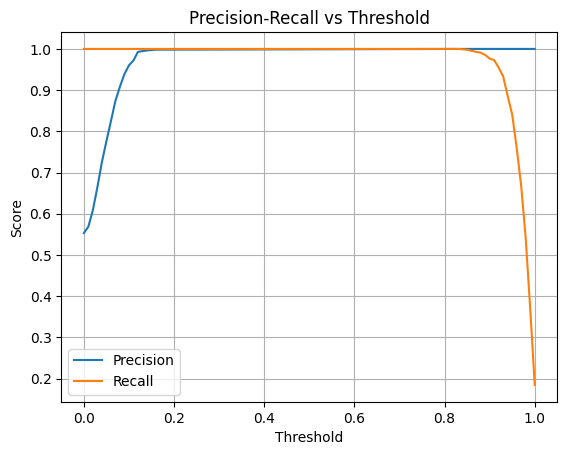


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       447
           1       1.00      1.00      1.00       553

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

ROC AUC Score: 1.0


In [92]:
clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c) # train this model as a binary classifier with RandomForestClassifier()
y_probs = clf.predict_proba(X_test_c)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_c, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

# Evaluate at default threshold = 0.5
y_pred_c = clf.predict(X_test_c)
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_c))
print("ROC AUC Score:", roc_auc_score(y_test_c, y_probs))


**🔍 Threshold Analysis**
- Precision and recall curves are both very high across most thresholds.
- The default threshold of 0.5 yields perfect performance, indicating strong model confidence.
- The curve shape suggests well-separated class probabilities, meaning the model is highly certain in its predictions.

In [96]:
# Create a results DataFrame to inspect predictions
results_df = pd.DataFrame({
    'Predicted_Label': y_pred_c,
    'True_Label': y_test_c.values,
    'Prediction_Probability': y_probs
})

# Sort by prediction probability (optional)
results_df = results_df.sort_values(by='Prediction_Probability', ascending=False)

# # View top results
# results_df.head(100)

grouped = results_df.groupby(['Prediction_Probability', 'Predicted_Label']).size().reset_index(name='Count')
grouped = grouped.sort_values(by='Prediction_Probability', ascending=False)

# View top rows
print(grouped.head(10))


    Prediction_Probability  Predicted_Label  Count
30                    1.00                1    102
29                    0.99                1    102
28                    0.98                1     95
27                    0.97                1     70
26                    0.96                1     51
25                    0.95                1     45
24                    0.94                1     25
23                    0.93                1     26
22                    0.92                1     12
21                    0.91                1     10


# 4.2. Multilabel Ranking Metrics 

**🎯 Goal:**
Evaluate how well the model ranks products by their predicted likelihood of being recommended, rather than just predicting a binary outcome.

**🛠️ What the Code Does:**

Simulates a ranking task by selecting the first 10 product-customer pairs.
Creates:
- y_true_rank: actual recommendation outcomes (1 = relevant, 0 = not relevant)
- y_score_rank: predicted probabilities of recommendation from the model

Feeds these into two ranking evaluation metrics:
- label_ranking_average_precision_score
- ndcg_score (Normalized Discounted Cumulative Gain)

In [23]:
# Simulated relevance + scores from first 10 predictions
y_true_rank = np.tile((merged_df['Recommend_Class'].values[:10] == 1).astype(int), (1, 1))
y_score_rank = np.tile(merged_df['Probability_of_Recommendation'].values[:10], (1, 1))

print("Label Ranking Average Precision Score:", label_ranking_average_precision_score(y_true_rank, y_score_rank))
print("NDCG Score:", ndcg_score(y_true_rank, y_score_rank))

Label Ranking Average Precision Score: 1.0
NDCG Score: 0.9999999999999999


In [24]:
# Select first customer from merged_df
customer_id = merged_df.iloc[0]['Customer_ID']

# Filter only rows belonging to that customer
customer_products = merged_df[merged_df['Customer_ID'] == customer_id]

# Sort by predicted probability (high to low)
ranked_products = customer_products.sort_values(by='Probability_of_Recommendation', ascending=False)

# Show top 5
ranked_products[['Product_ID', 'Probability_of_Recommendation', 'Recommend_Class']].head(5)

,Product_ID,Probability_of_Recommendation,Recommend_Class
59,P2059,0.99,1
38,P2038,0.96,1
41,P2041,0.96,1
75,P2075,0.95,1
89,P2089,0.94,1


In [25]:
# Sort by customer and descending probability
ranked_all = merged_df.sort_values(by=['Customer_ID', 'Probability_of_Recommendation'], ascending=[True, False])

# Get top 3 recommendations per customer
top3_per_customer = ranked_all.groupby('Customer_ID').head(3)

# View the results
top3_per_customer[['Customer_ID', 'Product_ID', 'Probability_of_Recommendation']]

,Customer_ID,Product_ID,Probability_of_Recommendation
59,C1000,P2059,0.99
38,C1000,P2038,0.96
41,C1000,P2041,0.96
159,C1001,P2059,0.99
138,C1001,P2038,0.96
...,...,...,...
19838,C1198,P2038,0.96
19841,C1198,P2041,0.96
19959,C1199,P2059,0.99
19938,C1199,P2038,0.96


# 6. Regression Setup – Predicting Recommendation Probability

**🎯 Objective:**
Transform the recommendation task into a regression problem by directly predicting the continuous variable Probability_of_Recommendation (a value between 0 and 1), rather than just predicting a binary “yes” or “no”.

**🛠️ What the Code Does:**
1. Feature and Target Selection
2. Train-Test Split 
3. Feature Scaling

**📈 Why This Matters:**
- Regression provides a more granular prediction: instead of binary yes/no, the model can rank products by how likely they are to be recommended.
- These scores are ideal for use cases like top-N recommendation lists, product rankings, or personalized scoring.


In [69]:
X = merged_df.drop(['Customer_ID', 'Product_ID', 'Probability_of_Recommendation', 'Similar_Product_List'], axis=1)
y = merged_df['Probability_of_Recommendation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
# Standardizes the features so they all have mean 0 and standard deviation 1
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# Cross-validation for regressor
reg_cv_scores = cross_val_score(RandomForestRegressor(), X_train_scaled, y_train, cv=5, scoring='r2')
print("Cross-validated R2 scores (Regressor):", reg_cv_scores)
print("Mean CV R2:", np.mean(reg_cv_scores))

Cross-validated R2 scores (Regressor): [1. 1. 1. 1. 1.]
Mean CV R2: 1.0


In [34]:
# Train regressor
regressor = RandomForestRegressor()
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import r2_score, root_mean_squared_error

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R² Score: 1.0
RMSE: 9.835508967892058e-16


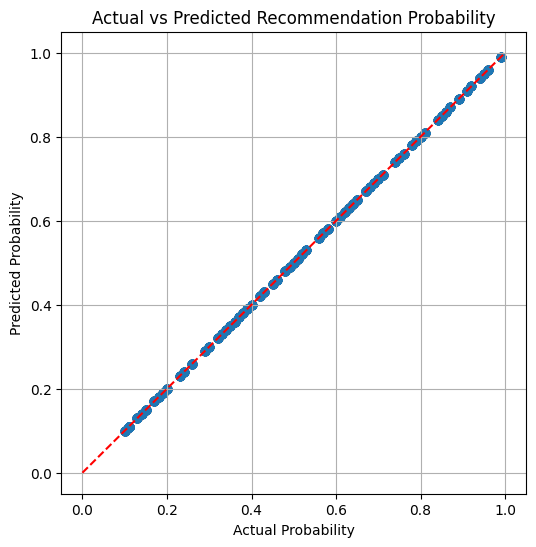

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal reference line
plt.xlabel("Actual Probability")
plt.ylabel("Predicted Probability")
plt.title("Actual vs Predicted Recommendation Probability")
plt.grid()
plt.show()

In [36]:
import pandas as pd

results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
})

# Sort by Actual or Predicted for readability
results_df = results_df.sort_values(by="Actual").reset_index(drop=True)

# View top 10
results_df.head(10)

,Actual,Predicted
0,0.1,0.1
1,0.1,0.1
2,0.1,0.1
3,0.1,0.1
4,0.1,0.1
5,0.1,0.1
6,0.1,0.1
7,0.1,0.1
8,0.1,0.1
9,0.1,0.1


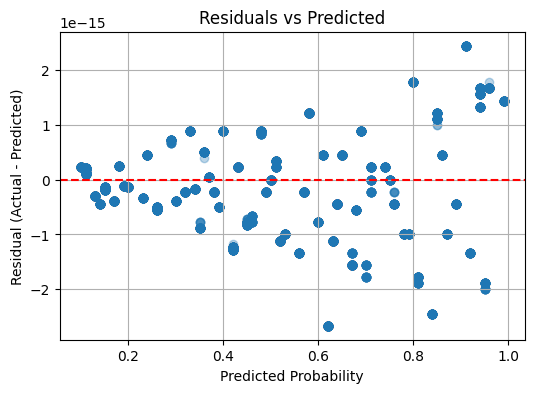

In [37]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Probability")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.grid()
plt.show()